# Import

In [5]:
import gymnasium as gym
import seaborn as sns
import os
from collections import deque, Counter, namedtuple, defaultdict
import random
from matplotlib import pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
import torch
from torch import nn
import torch.nn.functional as F
from torch.distributions import Categorical
import math
from itertools import count
from tqdm import tqdm
import numpy as np
import time

#Setting up matplotlib for live update the traiing progress
import matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

# Test env

  0%|          | 0/10 [00:00<?, ?it/s]/Users/jamesnguyen/anaconda3/envs/torch/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 10/10 [00:00<00:00, 133.50it/s]


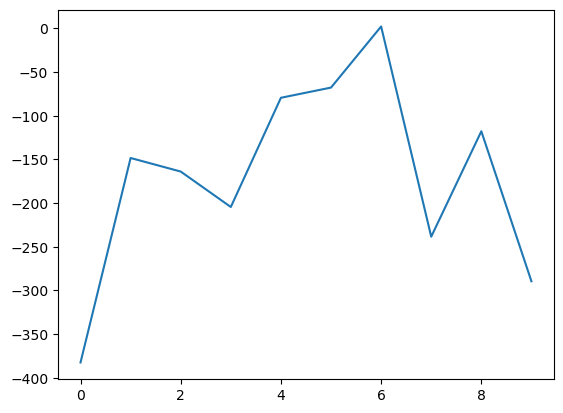

In [3]:
env = gym.make('LunarLander-v2')
obs, info = env.reset()

rewards = []
for ep in tqdm(range(10)):
    obs, info = env.reset()
    total_reward = 0

    for t in count():
        action = env.action_space.sample()
        state, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        if terminated or truncated: 
            break
    
    rewards.append(total_reward)

sns.lineplot(y = rewards, x = list(range(len(rewards))))
plt.show()
env.close()

In [24]:
p = torch.rand(2,5)
p = F.softmax(p)
print(p.shape)
print(p)

torch.Size([2, 5])
tensor([[0.3164, 0.1330, 0.1642, 0.1302, 0.2562],
        [0.2040, 0.1835, 0.2421, 0.1774, 0.1931]])


In [26]:
m = Categorical(p)
action = m.sample()
print(action)

tensor([4, 2])


# Model

In [31]:
a = torch.rand(10,2)
print(a)
print(F.softmax(a))

tensor([[0.1085, 0.1753],
        [0.0948, 0.4267],
        [0.3779, 0.2726],
        [0.3076, 0.7285],
        [0.6687, 0.7604],
        [0.1922, 0.3785],
        [0.9667, 0.4183],
        [0.8807, 0.7741],
        [0.0134, 0.3825],
        [0.7106, 0.2433]])
tensor([[0.4833, 0.5167],
        [0.4178, 0.5822],
        [0.5263, 0.4737],
        [0.3963, 0.6037],
        [0.4771, 0.5229],
        [0.4535, 0.5465],
        [0.6338, 0.3662],
        [0.5266, 0.4734],
        [0.4088, 0.5912],
        [0.6148, 0.3852]])


In [84]:
class ActorNet(nn.Module):

    def __init__(self, state_size, action_size, hidden_size = 128, lr = 1e-3, ) -> None:
        super().__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.hidden_size = hidden_size

        self.linear1 = nn.Linear(state_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size * 2)
        self.linear3 = nn.Linear(hidden_size * 2, action_size)

        self.optimizer = torch.optim.Adam(self.parameters(), lr = lr)

    def forward(self, X):
        X = F.relu(self.linear1(X))
        X = F.relu(self.linear2(X))
        X = F.softmax(self.linear3(X))
        return Categorical(X)


class CriticNet(nn.Module):
    def __init__(self, state_size, action_size, hidden_size = 128, lr = 1e-3) -> None:
        super().__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.hidden_size = hidden_size

        self.linear1 = nn.Linear(state_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size * 2)
        self.linear3 = nn.Linear(hidden_size * 2, 1)

        self.optimizer = torch.optim.Adam(self.parameters(), lr = lr)

    def forward(self, X):
        X = F.relu(self.linear1(X))
        X = F.relu(self.linear2(X))
        return self.linear3(X)


In [40]:
# Test model
env = gym.make('LunarLander-v2')
state, info = env.reset()

obs_space = len(state)
action_space = env.action_space.n
print('obs space = ', obs_space, ' action space = ', action_space)

state = torch.tensor(state).float().unsqueeze(0)
print(state.shape)

actor = ActorNet(8, 4)
critic = CriticNet(8, 4)

print('actor output =', actor(state))
print('critic output =', critic(state))

env.close()

obs space =  8  action space =  4
torch.Size([1, 8])
actor output = Categorical(probs: torch.Size([1, 4]))
critic output = tensor([[-0.0428]], grad_fn=<AddmmBackward0>)


In [57]:
x = torch.rand(5,10)
print(x)
a = Categorical(F.softmax(x))
print(a)
b = a.sample()
print(b)
c = a.log_prob(b)
print(c)

tensor([[0.0203, 0.1211, 0.0101, 0.0745, 0.4029, 0.2134, 0.4885, 0.0345, 0.8601,
         0.1719],
        [0.4498, 0.7515, 0.3743, 0.2629, 0.5579, 0.8219, 0.4741, 0.9996, 0.9229,
         0.5952],
        [0.5034, 0.8491, 0.1983, 0.9749, 0.9789, 0.1302, 0.1531, 0.7219, 0.4349,
         0.5534],
        [0.9517, 0.1013, 0.1726, 0.1832, 0.4002, 0.9294, 0.3629, 0.2119, 0.8884,
         0.6194],
        [0.3847, 0.8752, 0.2203, 0.8240, 0.9942, 0.8906, 0.5902, 0.4328, 0.4060,
         0.1881]])
Categorical(probs: torch.Size([5, 10]))
tensor([8, 5, 7, 5, 4])
tensor([-1.7191, -2.1288, -2.1779, -1.9082, -1.9283])


# Tune

In [81]:
def compute_returns(value, rewards, dones, gamma = 0.99):
    reward = value
    returns = []
    for step in reversed(range(len(rewards))):
        reward = rewards[step] * gamma * reward * dones[step]
        returns.append(reward)
    
    return list(reversed(returns))

In [89]:
actor = ActorNet(8, 4)
critic = CriticNet(8,4)
training_epochs = 5000
gamma = 0.99

loop = tqdm(range(training_epochs))
history = defaultdict(list)

env = gym.make('LunarLander-v2')
reward_window = deque() 

for epoch in loop:

    state, info = env.reset()

    log_probs = []
    values = []
    rewards = []
    dones = []
    entropy = 0
    done = False

    total_reward = 0

    for t in count():
        state = torch.tensor(state).float()
        action_prob = actor(state)
        value = critic(state)

        action = action_prob.sample()

        # calculates the logarithm of the probability density function (PDF) 
        # why we need log_prob? 
        log_prob = action_prob.log_prob(action).unsqueeze(0)
        log_probs.append(log_prob)

        action = action.cpu().numpy()
        next_state, reward, terminated, truncated, info = env.step(action)

        total_reward += reward

        values.append(value)

        reward = torch.tensor([reward]).float()
        rewards.append(reward)

        if terminated or truncated:
            done = True

        done = torch.tensor([1 - done]).float()

        dones.append(done)
        state = next_state

        if done:
            #epsiode terminated
            break
    
    next_state = torch.tensor(next_state).float()
    next_state_value = critic(next_state)
    returns = compute_returns(next_state_value, rewards, dones, gamma)
    
    log_probs = torch.cat(log_probs)
    values = torch.cat(values)
    returns = torch.cat(returns).detach()

    advantage = returns - values

    # reference
    # https://pytorch.org/docs/stable/distributions.html
    # the minus because of gradient ascend
    actor_loss = -(log_probs * advantage.detach()).mean()
    critic_loss = advantage.pow(2).mean()

    actor.optimizer.zero_grad()
    critic.optimizer.zero_grad()

    actor_loss.backward()
    critic_loss.backward()

    actor.optimizer.step()
    critic.optimizer.step()

    #update score
    reward_window.append(total_reward)
    avg_reward = np.mean(reward_window)

    loop.set_description(f'epoch = {epoch}, avg reward = {avg_reward}')

env.close()

epoch = 4999, avg reward = -0.5671602059107697: 100%|██████████| 5000/5000 [00:19<00:00, 251.04it/s] 
